In [49]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
import sys
sys.path.append('/home/zz1994/packages/ABCMB')

In [51]:
from classy import Class
import jax.numpy as jnp
import numpy as np
from jax import jit, vmap, lax, grad, config, jacfwd
from jax.scipy.special import gamma, factorial
import scipy
import equinox as eqx
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import time

from ABCMB import main, cosmology, perturbations, spectrum
from ABCMB import constants as cnst
from ABCMB import ABCMBTools as tools
from ABCMB.hyrex import hyrex

# Setup

In [4]:
model = main.Model(ellmin=2, ellmax=2500, lensing=False, has_MasslessNeutrinos=True, has_MassiveNeutrinos=False)

In [125]:
params = {
    'h': 0.6762,
    'omega_cdm': 0.1193,
    'omega_b': 0.0225,
    'A_s': 2.12424e-9,
    'n_s': 0.9709,
    'Neff': 3.044,
    'YHe': 0.245,
    'TCMB0': 2.34865418e-4,
    'T_nu': (4. / 11.)**(1. / 3.) * 2.34865418e-4,
    'N_ncdm': 0,
    'T_ncdm': 0.71611 * 2.34865418e-4,
    'm_ncdm': 0.06,
}
PT, BG = eqx.filter_jit(model.get_PTBG)(params)

/ext3/miniconda3/lib/python3.10/site-packages/equinox/_jit.py:55: UserWarning: `diffrax.diffeqsolve(..., discrete_terminating_event=...)` is deprecated in favour of the more general `diffrax.diffeqsolve(..., event=...)` interface. This will be removed in some future version of Diffrax.
  out = fun(*args, **kwargs)
/ext3/miniconda3/lib/python3.10/site-packages/equinox/_jit.py:55: UserWarning: `diffrax.diffeqsolve(..., discrete_terminating_event=...)` is deprecated in favour of the more general `diffrax.diffeqsolve(..., event=...)` interface. This will be removed in some future version of Diffrax.
  out = fun(*args, **kwargs)


In [5]:
BG = cosmology.ClassBackground()

In [42]:
PE = perturbations.PerturbationEvolver(model.perturbations_list, BG)

In [156]:
f = eqx.filter_jit(PE.full_evolution_scan)
for i in range(2):
    s = time.time()
    PT = f()
    print(time.time() - s)

83.56429409980774
83.74756288528442


In [19]:
SS = spectrum.SpectrumSolver(ellmin=2, ellmax=2500, lensing=False, switch_sw=1., switch_isw=1., switch_dop=1., switch_pol=1.)

In [145]:
# Turned off reionization, RSA and UFA
class_params = {
    "output": "mPk, tCl, pCl",
    #"temperature_contributions" : "tsw",
    'k_output_values' : "0.001, 0.01, 0.1",
    "l_max_scalars" : 3000,
    "z_max_pk": 1000,
    "H0": BG.params["h"]*100,
    "omega_b": BG.params["omega_b"],
    "omega_cdm": BG.params["omega_cdm"],
    "N_ur": BG.params["N_ur"],
    #"N_ur" : 3.044,
    "YHe": BG.params["YHe"],
    "lensing": "no",
    "N_ncdm": 0,
    "reio_parametrization" : "reio_none", 
    "gauge" : "synchronous", 
    "l_max_g": 50,
    "l_max_pol_g": 25,
    "l_max_ur": 30, 
    "radiation_streaming_trigger_tau_over_tau_k" : 1.e6,
    "radiation_streaming_trigger_tau_c_over_tau" : 1.e6,
    "ur_fluid_trigger_tau_over_tau_k" : 1.e5}    

class_lcdm = Class()
class_lcdm.set(class_params)
class_lcdm.compute()

# Thermodynamics Check

In [12]:
class_rec = class_lcdm.get_thermodynamics()

In [13]:
a = 1/(1.+class_rec["z"])
xe_class = class_rec["x_e"]
Tm_class = class_rec['Tb [K]'] * cnst.kB
xe_abcmb = BG.xe(jnp.log(a))
Tm_abcmb = BG.Tm(jnp.log(a))

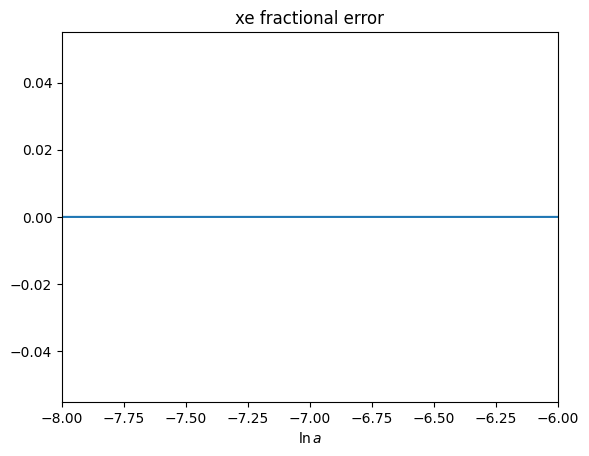

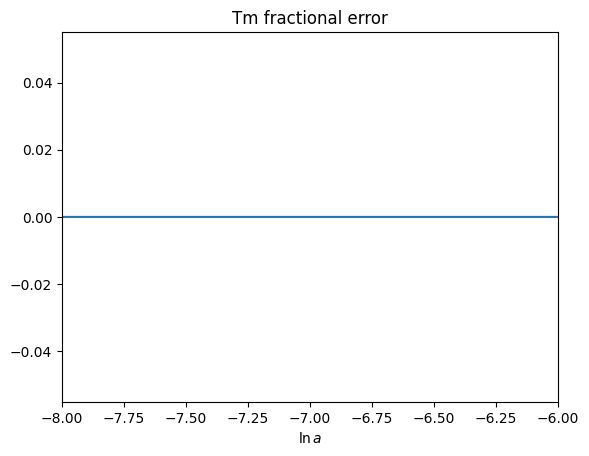

In [15]:
plt.plot(jnp.log(a), abs(xe_abcmb-xe_class)/xe_class)
#plt.yscale("log")
plt.xlabel(r"$\ln{a}$")
plt.title("xe fractional error")
plt.xlim((-8, -6))
plt.show()

plt.plot(jnp.log(a), abs(Tm_abcmb-Tm_class)/Tm_class)
#plt.yscale("log")
plt.xlabel(r"$\ln{a}$")
plt.xlim((-8, -6))
plt.title("Tm fractional error")
plt.show()

In [16]:
expkappa_class = class_rec['exp(-kappa)']
expkappa_abcmb = BG.expmkappa(jnp.log(a))

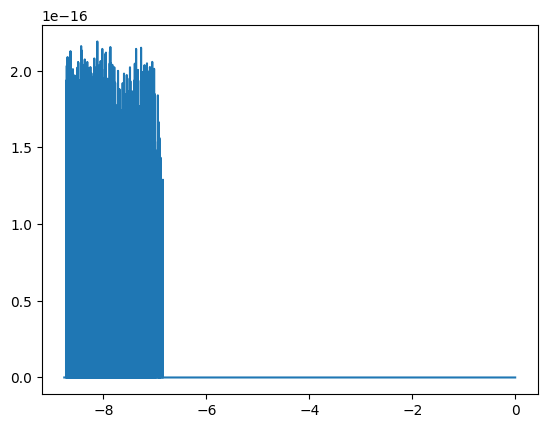

In [19]:
plt.plot(jnp.log(a), abs(expkappa_class-expkappa_abcmb)/expkappa_class)
#plt.yscale("log")
#plt.xlim((-8, -6))
#plt.ylim((1.e-5, 0.3))
plt.show()

In [20]:
g_class = class_rec['g [Mpc^-1]']
g_abcmb = BG.visibility(jnp.log(a))

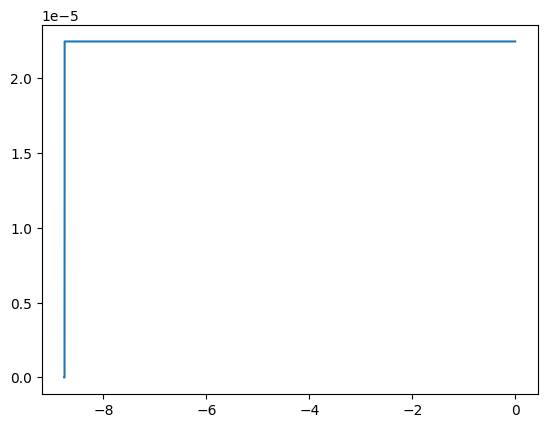

In [22]:
plt.plot(jnp.log(a), abs(g_abcmb-g_class)/g_class)
#plt.xlim((-8, -6))
#plt.yscale("log")
plt.show()

# Perturbations Check

In [146]:
class_pert = class_lcdm.get_perturbations()

In [24]:
PT.delta_g.shape

(500, 300)

In [113]:
interp_column = lambda k, col : jnp.interp(jnp.log10(k), jnp.log10(PT.k), col)

In [29]:
class_pert["scalar"][i].keys()

dict_keys(['tau [Mpc]', 'a', 'delta_g', 'theta_g', 'shear_g', 'pol0_g', 'pol1_g', 'pol2_g', 'delta_b', 'theta_b', 'psi', 'phi', 'delta_ur', 'theta_ur', 'shear_ur', 'delta_cdm', 'theta_cdm'])

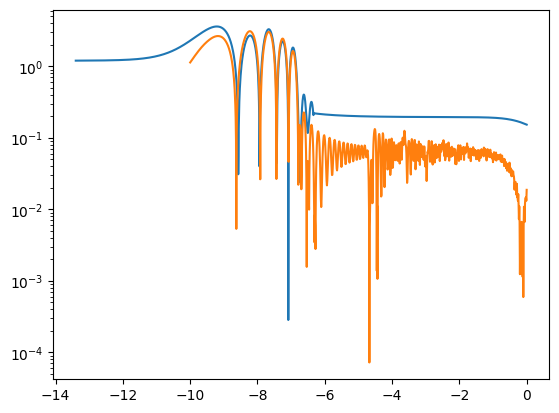

In [114]:
i = 2
abcmb_delta_g = vmap(interp_column, in_axes=(None, 0), out_axes=0)(jnp.array([0.001, 0.01, 0.1]), PT.delta_g)
plt.plot(jnp.log(class_pert["scalar"][i]["a"]), abs(class_pert["scalar"][i]["delta_g"]))
plt.plot(PT.lna, abs(abcmb_delta_g[:, i]))
plt.yscale("log")
plt.show()

This is the source function over $\ln{a}$ for the Transfer function of a given $k$. 

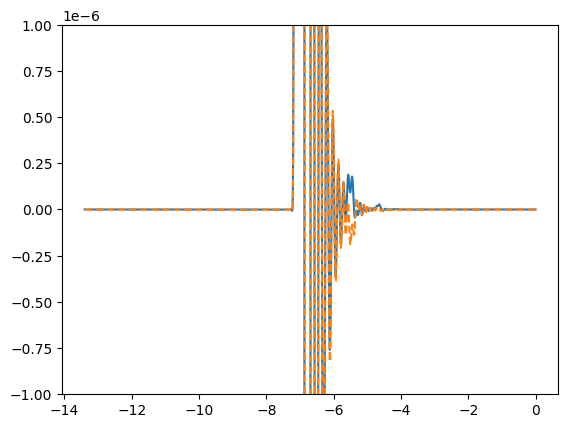

In [158]:
i = 2
abcmb_theta_g = vmap(interp_column, in_axes=(None, 0), out_axes=0)(jnp.array([0.001, 0.01, 0.1]), 2.*PT.sigma_g + PT.Gg0 + PT.Gg2)
af = lambda lna : jnp.interp(lna, PT.lna, abcmb_theta_g[:, i])
lna_class = jnp.log(class_pert["scalar"][i]["a"])

a = jnp.sqrt(6)/8. * af(lna_class) * BG.visibility(lna_class)
c = jnp.sqrt(6)/8.*(2*class_pert["scalar"][i]["shear_g"] +  class_pert["scalar"][i]["pol0_g"] + class_pert["scalar"][i]["pol2_g"])*BG.visibility(jnp.log(class_pert["scalar"][i]["a"]))
a = jnp.nan_to_num(a, 0.)
c = jnp.nan_to_num(c, 0.)
#plt.plot(lna_class, af(lna_class))
#plt.plot(lna_class, (2*class_pert["scalar"][i]["shear_g"] +  class_pert["scalar"][i]["pol0_g"] + class_pert["scalar"][i]["pol2_g"]), "--")
plt.plot(lna_class, a)
plt.plot(lna_class, c, "--")
#plt.yscale("log")
#plt.xlim((-3, 0))
plt.ylim((-1.e-6, 1.e-6))
#plt.xlabel(r"$\ln{a}$")
#plt.ylabel(r"$$")
plt.show()

In [148]:
lna_class

Array([-1.34007884e+01, -1.34007882e+01, -1.34007880e+01, ...,
       -1.94897880e-04, -4.07235928e-05,  0.00000000e+00], dtype=float64)

In [149]:
i=0
j=-1
print(jnp.trapezoid(c[i:j], lna_class[i:j]))
print(jnp.trapezoid(a[i:j], lna_class[i:j]))

0.0005361894463892984
0.0005324842074313815


In [150]:
i=140
j=-1
print(jnp.trapezoid(c[i:j], lna_class[i:j]))
print(jnp.trapezoid(a[i:j], lna_class[i:j]))

0.0005361894463892984
0.0005324842074313814


In [106]:
lna_class[545]

Array(-4.99917294, dtype=float64)

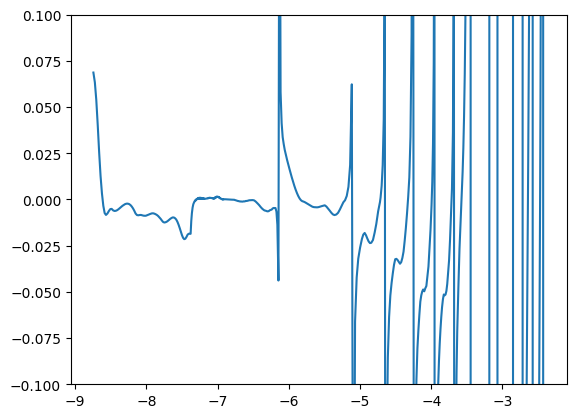

In [88]:
plt.plot(lna_class, (a-c)/c)
#plt.xlim((-8, 0.))
plt.ylim((-0.1, 0.1))
plt.show()

# Cl's

In [32]:
#class_pp = class_lcdm.raw_cl(3000)["pp"]
class_tt = class_lcdm.raw_cl(3000)["tt"]
class_te = class_lcdm.raw_cl(3000)["te"]
class_ee = class_lcdm.raw_cl(3000)["ee"]
class_ell = class_lcdm.raw_cl(3000)["ell"]

In [34]:
f = eqx.filter_jit(model.SS.get_Cl)
for i in range(2):
    s=time.time()
    cls = f(PT, BG)
    cls[0].block_until_ready()
    print(time.time()-s)

12.81542181968689
10.306378364562988


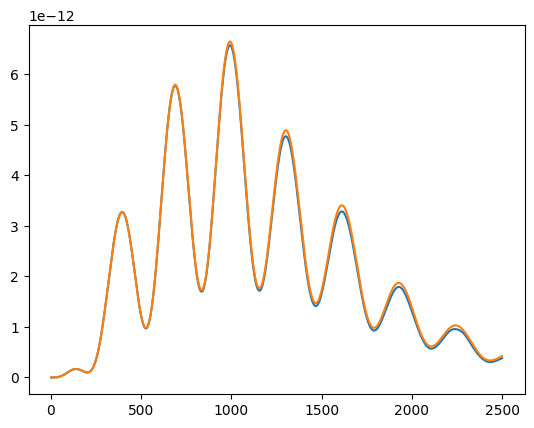

In [36]:
l = model.SS.ells
plt.plot(l, l*(l+1)*cls[2]/2./jnp.pi)
int_cl = jnp.interp(l, class_ell, class_ee)
plt.plot(l, l*(l+1)*int_cl/2./jnp.pi)
#plt.yscale("log")
#plt.xlim((2, 10))
plt.show()

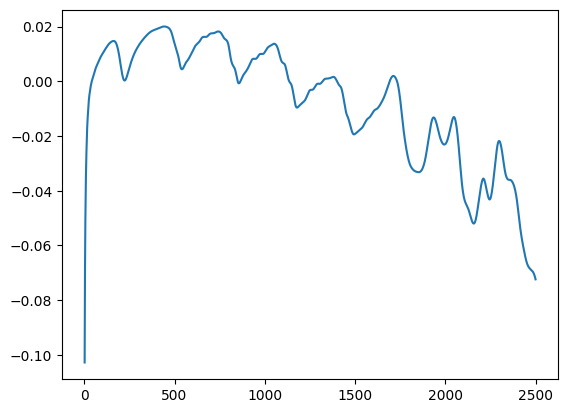

In [132]:
plt.plot(l, (cls[2]-int_cl)/int_cl)

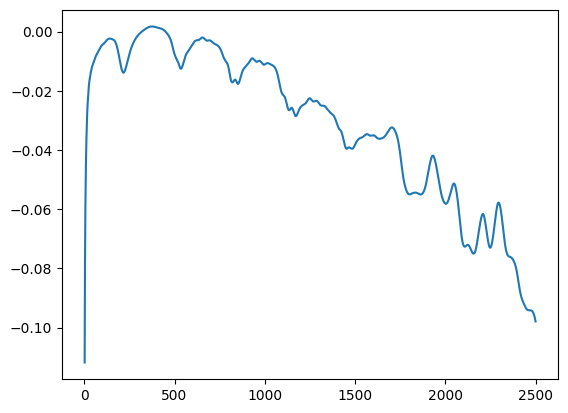

In [37]:
plt.plot(l, (cls[2]-int_cl)/int_cl)

# P(k)

In [5]:
class_pk = np.loadtxt("/home/zz1994/packages/class/output/ABCMB_test/noneutrinos00_pk.dat")
k_class = class_pk[:, 0]*BG.params["h"]
Pk_class = class_pk[:, 1]/BG.params["h"]**3

In [15]:
k = jnp.logspace(-4., -0.3, 500, base=10)
Pk = SS.Pk_lin(k, 0., PT, BG)

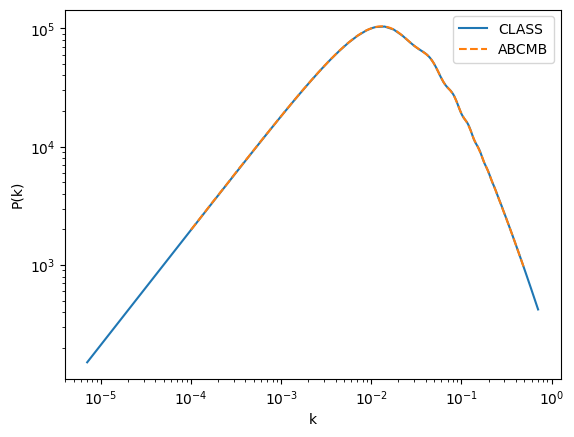

In [16]:
plt.loglog(k_class, Pk_class, label="CLASS")
plt.loglog(k, Pk, "--", label="ABCMB")
plt.legend()
#plt.xlim((1.e-3, 1))
plt.xlabel("k")
plt.ylabel("P(k)")
plt.show()

In [7]:
from classy import Class

In [16]:
class_params = {
    "output": "mPk, lCl",
    "lensing": "yes",
    "z_max_pk": 1000,
    "H0": BG.params["h"]*100,
    "omega_b": BG.params["omega_b"],
    "omega_cdm": BG.params["omega_cdm"],
    "tau_reio": 0.0586,
    "N_ur": BG.params["N_ur"],
    "YHe": BG.params["YHe"],
    "lensing": "no",
    "N_ncdm": 0}    

In [17]:
class_lcdm = Class()
class_lcdm.set(class_params)
class_lcdm.compute()

In [18]:
zs = jnp.array([0., 10., 100., 1000.])
k = jnp.logspace(-4., -0.3, 500, base=10)

/state/partition1/job-66401383/ipykernel_1291522/4275723911.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


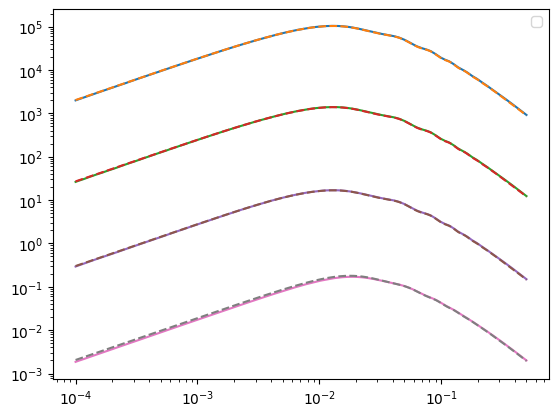

In [25]:
for z in zs:
    abcmb_res = SS.Pk_lin(k, z, PT, BG)
    class_res = np.vectorize(class_lcdm.pk_lin)(k, z)
    plt.loglog(k, SS.Pk_lin(k, z, PT, BG))
    plt.loglog(k, np.vectorize(class_lcdm.pk_lin)(k, z), "--")
    #plt.loglog(k, abs(abcmb_res - class_res)/class_res, label=z)
plt.legend()
plt.show()

# Lensing

## Lensing Cl

In [30]:
class_pp = class_lcdm.raw_cl(3000)["pp"]
class_tt = class_lcdm.raw_cl(3000)["tt"]
class_te = class_lcdm.raw_cl(3000)["te"]
class_ee = class_lcdm.raw_cl(3000)["ee"]
class_ell = class_lcdm.raw_cl(3000)["ell"]
abcmb_pp = vmap(SS.lensing_Cl, in_axes=(0, None, None))(class_ell, PT, BG)

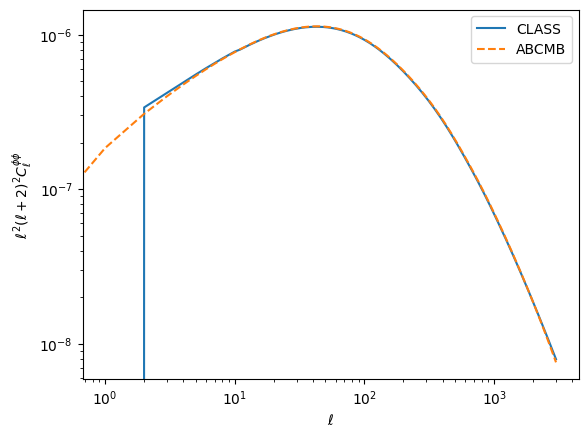

In [31]:
plt.plot(class_ell, (class_ell*(class_ell+1))**2 * class_pp, label="CLASS")
plt.plot(class_ell, (class_ell*(class_ell+1))**2 * abcmb_pp, "--", label="ABCMB")
plt.legend()
plt.xscale("log")
plt.yscale("log")
#plt.xlim((2, 2000))
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell^2(\ell+2)^2C_\ell^{\phi\phi}$")
plt.show()

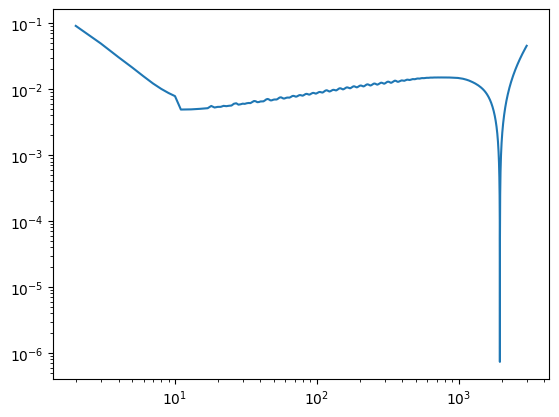

In [32]:
plt.plot(class_ell, abs(class_pp - abcmb_pp)/class_pp)
plt.xscale("log")
plt.yscale("log")
#plt.xlim((2, 2000))
plt.show()

## Temperature Cl

$$
C_\ell = \int_{0.98}^{1} \xi(\beta) J_0(\ell \beta) d\cos{\beta}
$$

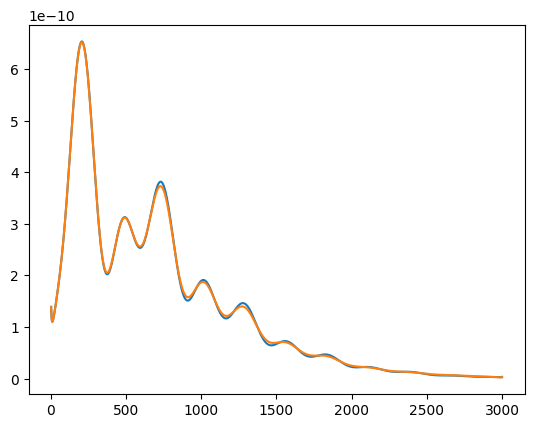

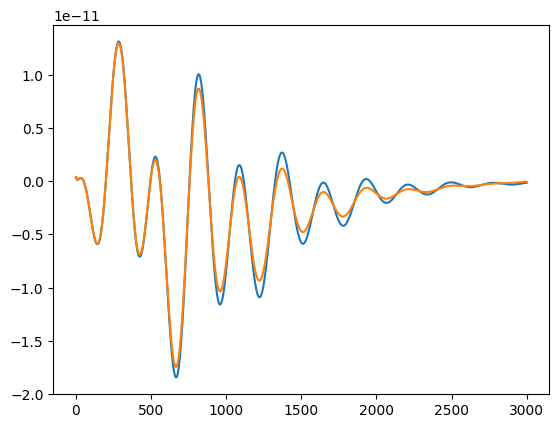

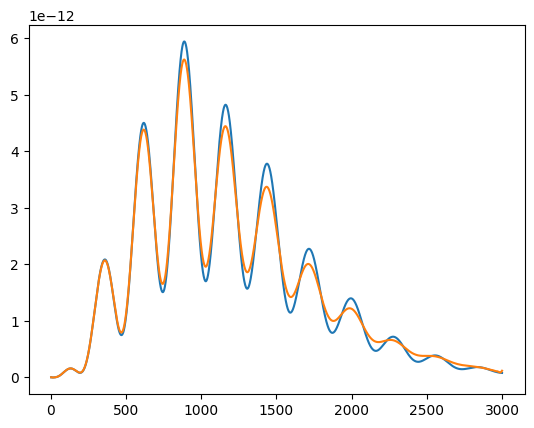

In [36]:
#res = SS.lense_ClTT(class_ell[2:], class_pp[2:], class_ell[2:]*(class_ell[2:]+1)*class_tt[2:]/2./jnp.pi)
#plt.loglog(class_ell[2:], class_ell[2:]*(class_ell[2:]+1)*res)
#ells = jnp.arange(2, 2000)
ells = class_ell[2:]
cltt = class_tt[2:]
clte = class_te[2:]
clee = class_ee[2:]
clpp = class_pp[2:]
pref = ells*(ells+1)/2./jnp.pi
#clpp = jnp.zeros(ells.size)
res_tt, res_te, res_ee = eqx.filter_jit(SS.lensed_Cls)(ells, cltt, clte, clee, PT, BG)
plt.plot(ells, pref*cltt)
plt.plot(ells, pref*(res_tt+cltt))
plt.show()

plt.plot(ells, pref*clte)
plt.plot(ells, pref*(res_te+clte))
plt.show()

plt.plot(ells, pref*clee)
plt.plot(ells, pref*(res_ee+clee))
plt.show()

In [47]:
f = eqx.filter_jit(SS.lensed_Cls)
for i in range(2):
    s = time.time()
    res_tt, res_te, res_ee = f(ells, cltt, clte, clee, PT, BG)
    res_tt.block_until_ready()
    print(time.time() - s)

16.553486347198486
11.142034769058228


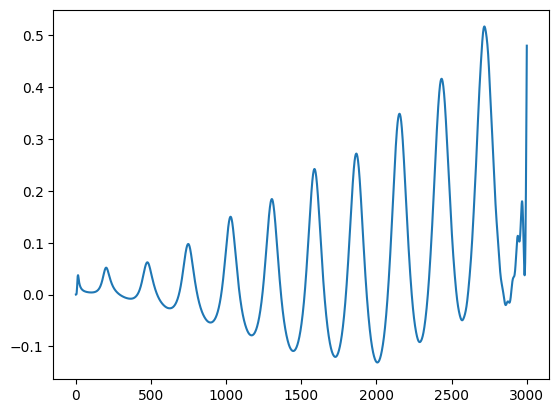

In [304]:
#plt.plot(ells, res_tt/cltt)
#plt.plot(ells, res_te/clte)
plt.plot(ells, res_ee/clee)
plt.show()

## Wigner Matrices

In [104]:
f = jit(tools.lensing_d00)
betas = jnp.linspace(0, jnp.pi/16., 1000)
l     = jnp.arange(2, 1003)
mu    = jnp.cos(betas)
print(f(mu, l).shape)

(1000, 1001)


In [55]:
betas = jnp.linspace(0, jnp.pi/16., 1000)
l     = jnp.arange(2, 1000)
mu    = jnp.cos(betas)

d00  = tools.lensing_d00(mu, l)
d11  = tools.lensing_d11(mu, l)
d1m1 = tools.lensing_d1m1(mu, l)
d2m2 = tools.lensing_d2m2(mu, l)

In the large $\ell$ limit, the Wigner matrices approach Bessel J functions as
$$
\lim_{\ell\rightarrow \infty}d_{mn}^{\ell}(\beta) \longrightarrow (-1)^{n-m} J_{m-n}(\ell \beta)\, .
$$
It serves to check the asymptotic behavior to make sure the recursion relations were correct.

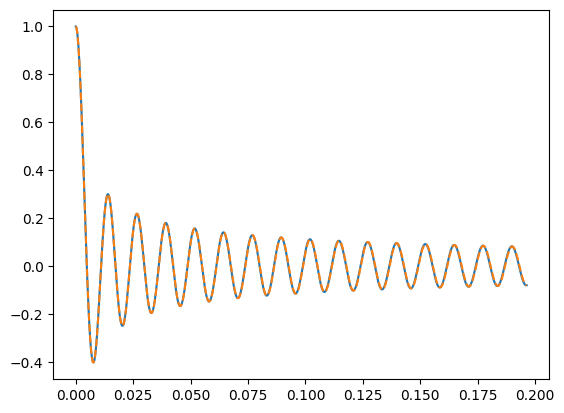

In [19]:
l = 500
plt.plot(betas, d00[:, l-2])
plt.plot(betas, scipy.special.jv(0, l*betas), "--")
plt.show()

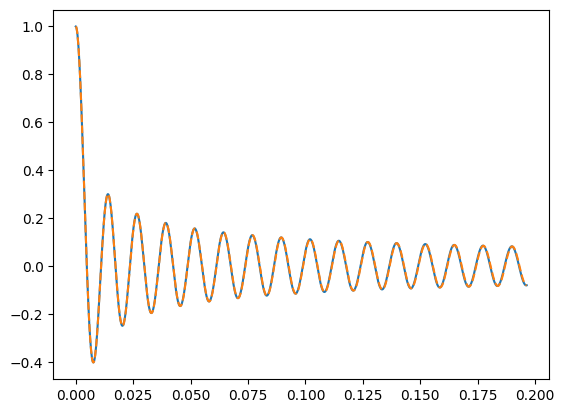

In [20]:
l = 500
plt.plot(betas, d11[:, l-2], label="d11")
plt.plot(betas, scipy.special.jv(0, l*betas), "--")
plt.show()

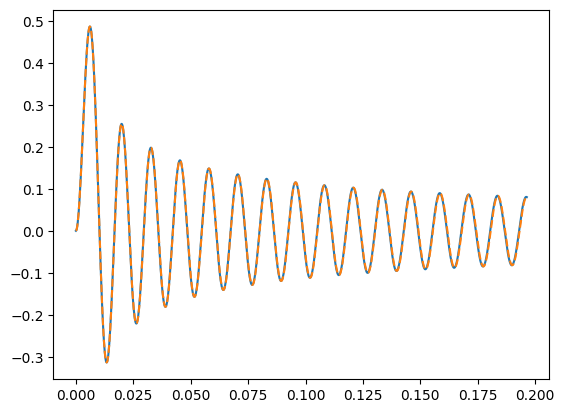

In [21]:
l = 500
plt.plot(betas, d1m1[:, l-2], label="d1m1")
plt.plot(betas, scipy.special.jv(2, l*betas), "--")
plt.show()

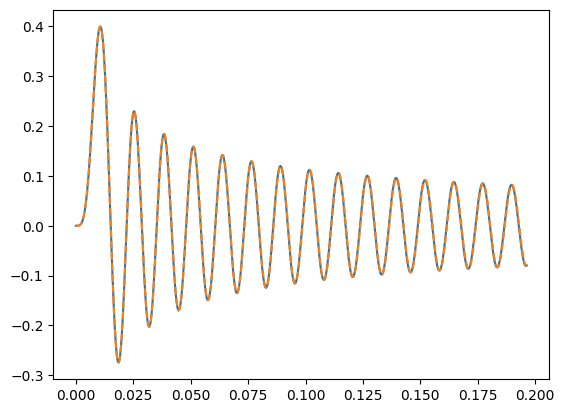

In [62]:
l = 500
plt.plot(betas, d2m2[:, l-2], label="d1m1")
plt.plot(betas, scipy.special.jv(4, l*betas), "--")
plt.show()

In [233]:
# Attempt at general solution
def wigner_d_matrix(mu, ells, m, n):
    """
    m, n are integers. m must be positive and greater than n.
    ells an array ([m, m+1, m+2, ..., ellmax])
    """
    
    # base case: ell = m
    def base_val(mu):
        beta = jnp.arccos(mu)
        norm = jnp.sqrt((2*m+1)/2) * jnp.sqrt(factorial(2*m)/(factorial(m+n)*factorial(m-n)))
        return norm * jnp.cos(beta/2.)**(m+n)*(-jnp.sin(beta/2.))**(m-n)
        #return norm * jnp.sqrt((1+mu)/2)**(m+n) * jnp.sqrt((1-mu)/2)**(m-n)

    normA = jnp.sqrt((2*ells+3)/(2*ells+1))
    normC = jnp.sqrt((2*ells+3)/(2*ells-1))
    denom = jnp.sqrt((ells+1)**2-m**2) * jnp.sqrt((ells+1)**2-n**2)
    A = jnp.nan_to_num(normA * (ells+1)*(2*ells+1) / denom, 0)
    B = jnp.nan_to_num(-A * m * n / ells / (ells+1), 0)
    C = jnp.nan_to_num(-normC * jnp.sqrt(ells**2-m**2) * jnp.sqrt(ells**2-n**2) / denom * (ells+1)/ells, 0)

    def one_mu(mu):
        d_start = base_val(mu) # Corresponds to ellmin = m
                
        def recursive_dlp1(carry, inputs):
            # For the first iteration, will take d1 and d2, compute d3.
            dl, dlm1 = carry 
            a, b, c = inputs

            # Compute dlp1
            dlp1 = a*mu*dl + b*dl + c*dlm1

            # Save dl, then make dl->dlm1, dlp1->dl
            return (dlp1, dl), dl

        # run scan for l = 2..lmax-1
        (_, _), res = lax.scan(recursive_dlp1, (d_start, 0.), (A, B, C))
        return res * jnp.sqrt(2./(2.*ells+1))

    return vmap(one_mu)(mu)

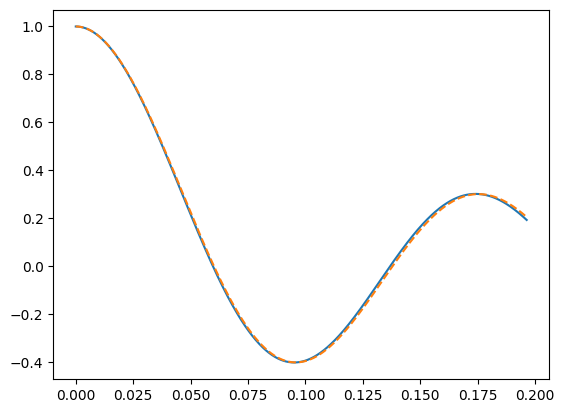

In [245]:
m = 4
n = 4
betas = jnp.linspace(0, jnp.pi/16., 1000)
l     = jnp.arange(m, 1000)
mu    = jnp.cos(betas)
d = jit(wigner_d_matrix)(mu, l, m, n)

l_plot = 10*m
plt.plot(betas, d[:, l_plot-m])
plt.plot(betas, (-1)**(n-m)*scipy.special.jv(m-n, l_plot*betas), "--")
plt.show()

In [248]:
d.shape
zeros = jnp.zeros((mu.size, m-2))
d_patched = jnp.concatenate((zeros, d), axis=1)

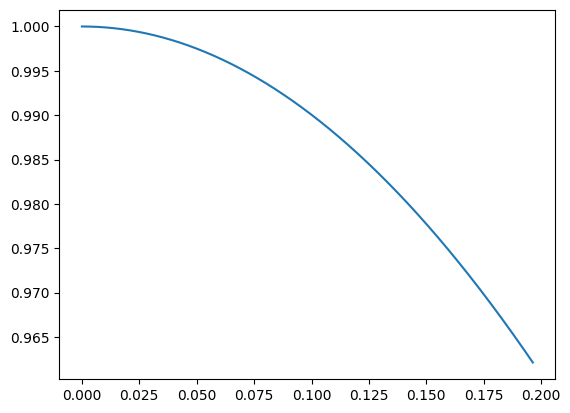

In [252]:
plt.plot(betas, d_patched[:, 2])

In [280]:
arr = jnp.ones(5)

5